# Third version of ML model

In [12]:
# import all needed libs
import pandas as pd
import numpy as np

# read datasets into datadframe
train_set = pd.read_pickle('../train_val_test_data/train_set.pkl')
validation_set = pd.read_pickle('../train_val_test_data/validation_set.pkl')
test_set = pd.read_pickle('../train_val_test_data/test_set.pkl')

# Remove all NaN rows / TODO: investigate and improve this 
train_set = train_set.dropna(subset=['Umsatz'])
validation_set = validation_set.dropna(subset=['Umsatz'])

# check if NaN left
#print(test_set.isna().sum())

#train_set.head()

train_set.columns

Index(['Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'Wettercode', 'Jahr_Monat', 'monthly_mean_temp',
       'monthly_mean_temp_diff', 'sunny', 'Wind_Kategorie', 'rainday',
       'snowday', 'KielerWoche', 'Salesindex', 'HolyCode', 'SchholCode',
       'BinHoly', 'BinSchhol', 'BinElec', 'DayOfWeek', 'weekend'],
      dtype='object')

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def prepare_features(data_df):
    # Define categorical features
    categorical_features = ['Warengruppe', 'Wind_Kategorie', 'DayOfWeek']

    # Ensure categorical columns are treated as categories
    for col in categorical_features:
        data_df[col] = data_df[col].astype('category')

    # Encode categorical variables using pd.get_dummies
    features = pd.get_dummies(data_df[categorical_features], drop_first=True, dtype=int)

    # Include any numeric or binary columns that are not categorical
    features['sunny'] = data_df['sunny']
    features['rainday'] = data_df['rainday']
    features['snowday'] = data_df['snowday']
    features['Salesindex'] = data_df['Salesindex']
    features['monthly_mean_temp_diff'] = data_df['monthly_mean_temp_diff']
    features['KielerWoche'] = data_df['KielerWoche']
    features['BinHoly'] = data_df['BinHoly']
    features['BinSchhol'] = data_df['BinSchhol']
    features['weekend'] = data_df['weekend']

    return features

# We need separated features and labels

# create the lable first
training_features = prepare_features(train_set)
validation_features = prepare_features(validation_set)
test_features = prepare_features(test_set)

# Add Umsatz to training and validation lables
training_labels = train_set[['Umsatz']]
validation_labels = validation_set[['Umsatz']]
# test_data contains no lable for Umsatz 

# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column

model = Sequential([
  InputLayer(shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(64, activation='relu'),
  Dropout(0.1),
  Dense(32, activation='relu'),
  Dropout(0.1),
  Dense(16, activation='relu'),
  Dropout(0.1),
  Dense(8, activation='relu'),
  Dense(1, activation='linear')
])

model.summary()

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

# Early Stopping Callback to prevent overfitting and long waiting for convergations
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(training_features, training_labels, epochs=250,
                    validation_data=(validation_features, validation_labels),  
                    callbacks=[early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 22)             │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,313 (16.85 KB)

 Trainable params: 4,269 (16.68 KB)

 Non-trainable params: 44 (176.00 B)

Epoch 1/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 51235.6172 - val_loss: 16310.2324
Epoch 2/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8865.8086 - val_loss: 4709.9321
Epoch 3/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7699.3247 - val_loss: 4655.1865
Epoch 4/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7098.5542 - val_loss: 4746.2017
Epoch 5/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7821.1562 - val_loss: 4386.3799
Epoch 6/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7181.9243 - val_loss: 4515.0337
Epoch 7/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6875.3857 - val_loss: 4271.4062
Epoch 8/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7179.6553 - val_loss: 4724.4688
Epoch 9/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7335.1992 - val_loss: 4418.8540
Epoch 10/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7535.9121 - val_loss: 4424.7725
Epoch 11/250
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8506.

In [14]:
model.save("python_model_v3.keras")

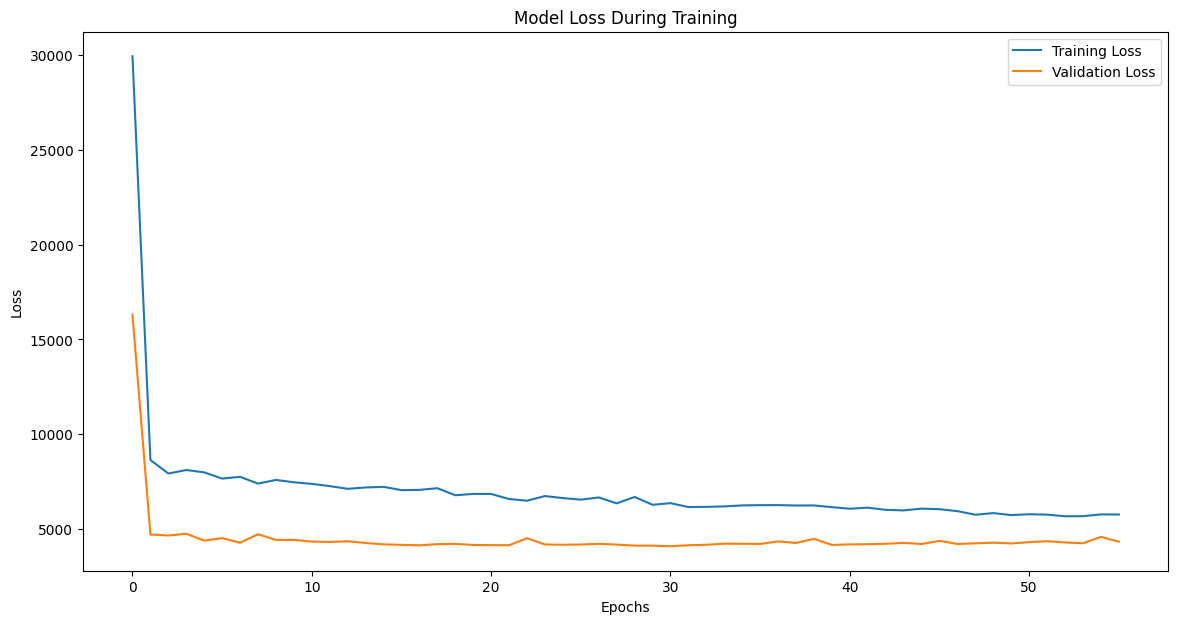

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Making Predictions and Evaluating the Model
Let's use the model to make predictions on our training and validation sets and evaluate the model's performance using Mean Absolute Percentage Error (MAPE).

In [20]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten() 
    non_zero_mask = y_true != 0
    if np.any(non_zero_mask):  # Überprüfung, ob es nicht-null Werte gibt
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    else:
        return float('inf')  # oder eine andere Behandlung für den Fall, dass alle y_true Werte null sind

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

# Validation DataFrame erstellen
validation_data = pd.DataFrame(validation_features)
validation_data['prediction'] = validation_predictions
validation_data['actual'] = validation_labels

# Warengruppe-Spalte identifizieren
warengruppen_columns = [col for col in validation_data.columns if 'Warengruppe' in col]

# MAPE für jede Warengruppe berechnen
mape_per_warengruppe = {}


# Berechne MAPE für Warengruppe 1.0
warengruppe_1_data = validation_data[(validation_data[warengruppen_columns] == 0).all(axis=1)]
if not warengruppe_1_data.empty:
    mape_per_warengruppe['Warengruppe_1.0'] = mape(warengruppe_1_data['actual'], warengruppe_1_data['prediction'])

for col in warengruppen_columns:
    warengruppe_data = validation_data[validation_data[col] == 1]
    if not warengruppe_data.empty:
        mape_per_warengruppe[col] = mape(warengruppe_data['actual'], warengruppe_data['prediction'])

# Ergebnisse ausgeben
for warengruppe, mape_value in mape_per_warengruppe.items():
    print(f"MAPE for {warengruppe}: {mape_value:.2f}%")

  1/235 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
MAPE on the Training Data: 22.58%
MAPE on the Validation Data: 25.03%
MAPE for Warengruppe_1.0: 22.98%
MAPE for Warengruppe_2.0: 20.79%
MAPE for Warengruppe_3.0: 29.94%
MAPE for Warengruppe_4.0: 26.59%
MAPE for Warengruppe_5.0: 17.93%
MAPE for Warengruppe_6.0: 69.26%


### Plot predictions

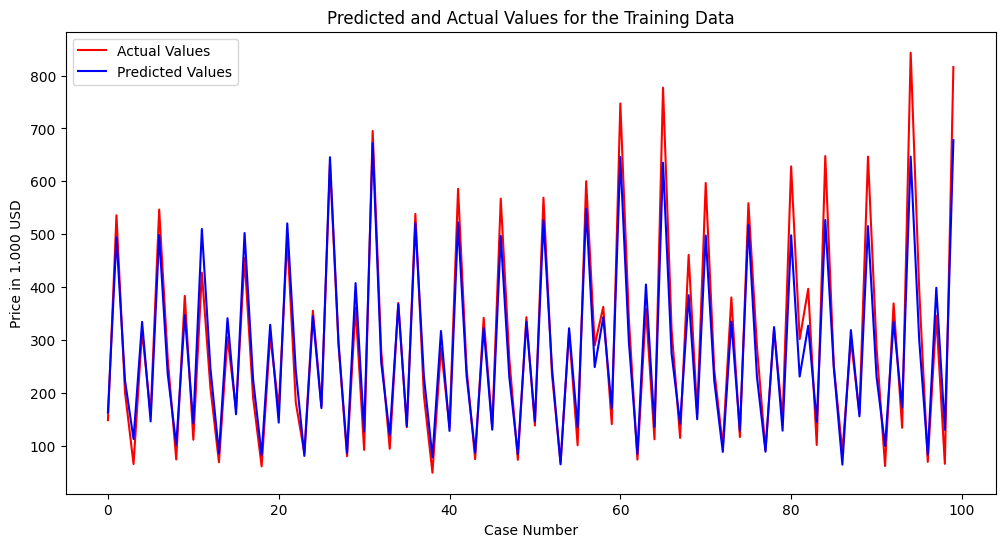

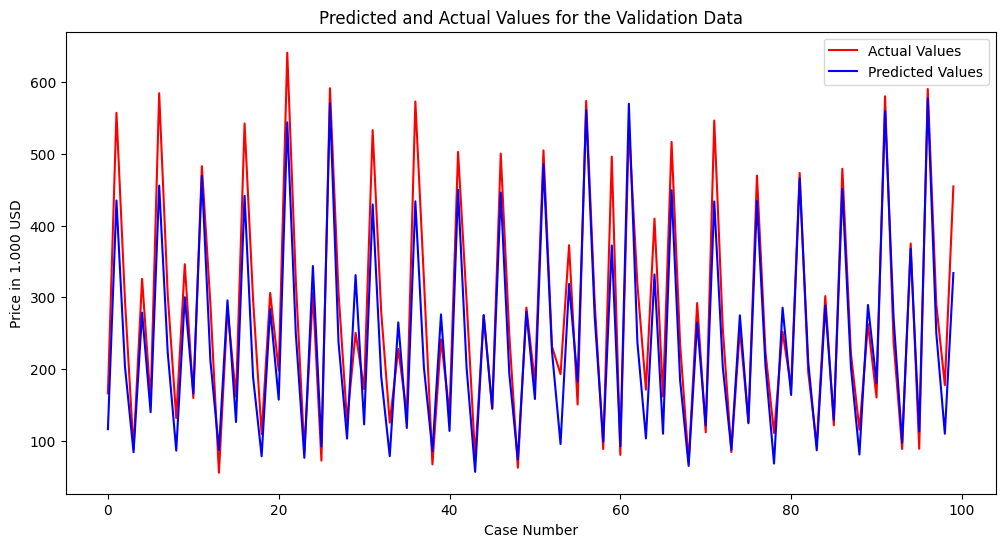

In [17]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Price in 1.000 USD')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

### Calculate test results to submit to kaggle

In [18]:
# calculate predictions for testdata
test_predictions = model.predict(test_features)

# flatten and convert from numpy into pandas dataframe
test_predictions = np.array(test_predictions).flatten()
test_predictions_df = pd.DataFrame({'Umsatz': test_predictions})

test_predictions_df.head()

test_set.head()

# merge the IDs from test date togther with Umsatz predictions
# TODO: check if we have any problems because of no common date index on both dataframes
submission_set = pd.concat([test_set['id'], test_predictions_df['Umsatz']], axis=1)

# Check if the count of dataset is correct for kaggle upload
if submission_set.shape[0] == 1830:
    print("OK : DataFrame has exact 1830 Entries!")
else:
    print(f"ERROR Dataframe has wrong number of {submission_set.shape[0]} Entries!")

# store the submission data
submission_set.to_csv('../prediction_data/submission.csv', index=False)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


OK : DataFrame has exact 1830 Entries!
